## Modelling Approach 2
Let's start by clarifying that Exercise Intensity is a ranking system so actually we are faced with multi-classification task, but our task will be solved with the use of regression models. Selected scoring metric will be MSE.

We'll be trying following regression models:

Logistic regression

Random Forest

XGBoost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
state = np.random.RandomState(12345)

In [2]:
df=pd.read_csv('data.csv')
df

,Exercise,Calories Burn,Dream Weight,Actual Weight,Age,Gender,Duration,Heart Rate,BMI,Weather Conditions,Exercise Intensity,Weight Difference,Gain,Height
0,Exercise 2,286.959851,91.892531,96.301115,45.0,Male,37.0,170.0,29.426275,Rainy,5.0,4.408585,Lose,1.809039
1,Exercise 7,343.453036,64.165097,61.104668,25.0,Male,43.0,142.0,21.286346,Rainy,5.0,3.060429,Gain,1.694286
2,Exercise 4,261.223465,70.846224,71.766724,20.0,Male,20.0,148.0,27.899592,Cloudy,4.0,0.920500,Lose,1.603846
3,Exercise 5,127.183858,79.477008,82.984456,33.0,Male,39.0,170.0,33.729552,Sunny,10.0,3.507448,Lose,1.568531
4,Exercise 10,416.318374,89.960226,85.643174,29.0,Female,34.0,118.0,23.286113,Cloudy,3.0,4.317052,Gain,1.917776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100063,Exercise 2,205.872575,80.355223,70.516820,22.0,Female,48.0,153.0,63.267795,Cloudy,3.0,9.838402,Gain,1.055735
100064,Exercise 2,294.547811,98.703186,70.516820,22.0,Male,53.0,148.0,51.359265,Cloudy,4.0,28.186366,Gain,1.171755
100065,Exercise 2,258.779574,91.311974,84.096481,54.0,Male,35.0,166.0,61.164229,Cloudy,9.0,7.215494,Gain,1.172574
100066,Exercise 3,269.916192,94.630249,85.552996,28.0,Male,55.0,166.0,39.910834,Rainy,5.0,9.077252,Gain,1.464105


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100068 entries, 0 to 100067
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Exercise            100068 non-null  object 
 1   Calories Burn       100068 non-null  float64
 2   Dream Weight        100068 non-null  float64
 3   Actual Weight       100068 non-null  float64
 4   Age                 100068 non-null  float64
 5   Gender              100068 non-null  object 
 6   Duration            100068 non-null  float64
 7   Heart Rate          100068 non-null  float64
 8   BMI                 100068 non-null  float64
 9   Weather Conditions  100068 non-null  object 
 10  Exercise Intensity  100068 non-null  float64
 11  Weight Difference   100068 non-null  float64
 12  Gain                100068 non-null  object 
 13  Height              100068 non-null  float64
dtypes: float64(10), object(4)
memory usage: 10.7+ MB


Traing and Spliting

In [4]:
cat_features = [
    'Exercise', 
    'Gender', 
    'Weather Conditions', 
    'Gain'
]

num_features = [
    'Dream Weight', 
    'Actual Weight', 
    'Age', 
    'Duration', 
    'Heart Rate', 
    'BMI', 
    'Weight Difference',
    'Height'   
]

target = 'Exercise Intensity'

X_train, X_test, y_train, y_test = train_test_split(
    df[cat_features+num_features], 
    df[target], 
    test_size=0.33, 
    random_state=state
)

In [5]:
# Pipeline stuff
# adding imputer in case future df updates will be with NaNs

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('normalizer', Normalizer())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant')),
        ('encoder', OrdinalEncoder())
    ]
)

preprocessor = ColumnTransformer(
   transformers=[
       ('numeric', numeric_transformer, num_features),
       ('categorical', categorical_transformer, cat_features)
   ]
)

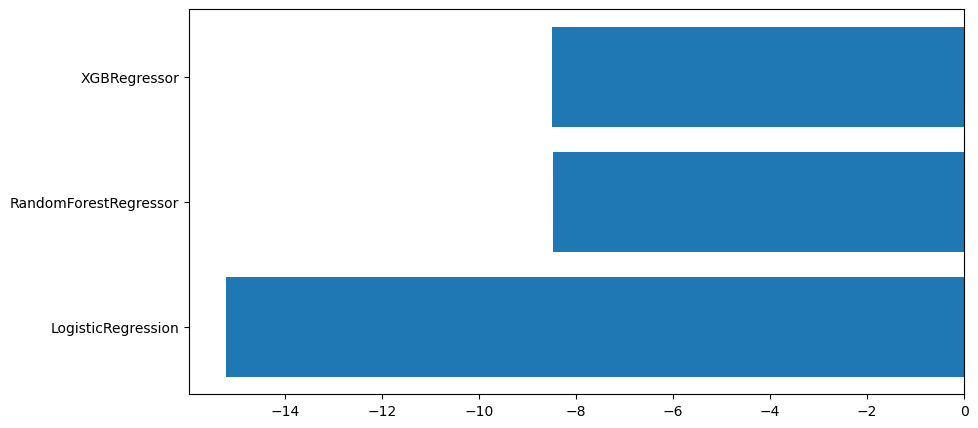

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

regressors = [
    LogisticRegression(),
    RandomForestRegressor(),
    XGBRegressor()
]

models = []
scores = []

for regressor in regressors:
    steps = [
        ('preprocess', preprocessor),
        ('reg', regressor)
    ]
    pipeline = Pipeline(steps)
    scorer = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    models.append(type(regressor).__name__)
    scores.append(scorer.mean())

plt.figure(figsize=(10, 5))
plt.barh(models, scores)
plt.show()


XGB Boost has lowest MSE. 
## Model Tuning
We will be tuning in two steps, starting with RandomSearchCV and then getting best parameters possible with GridSearchCV

In [7]:
loss = ['quantile', 'squared_error', 'absolute_error', 'huber']
max_features = ['sqrt', 'log2', None]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 15)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]

hyperparameter_grid = {
    'reg__loss': loss,
    'reg__max_features': max_features,
    'reg__n_estimators': n_estimators,
    'reg__max_depth': max_depth,
    'reg__min_samples_split': min_samples_split,
    'reg__min_samples_leaf': min_samples_leaf
}

random_cv = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=hyperparameter_grid,
    cv=3,
    n_iter=200,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=state
)

random_cv.fit(X_train, y_train)

print()
print('Best params:')
print(random_cv.best_params_)
print()
print('Best score:', random_cv.best_score_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[08:05:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "loss", "max_features", "min_samples_leaf", "min_samples_split" } are not used.


Best params:
{'reg__n_estimators': 50, 'reg__min_samples_split': 12, 'reg__min_samples_leaf': 50, 'reg__max_features': 'sqrt', 'reg__max_depth': 1, 'reg__loss': 'quantile'}

Best score: -8.23175050524211


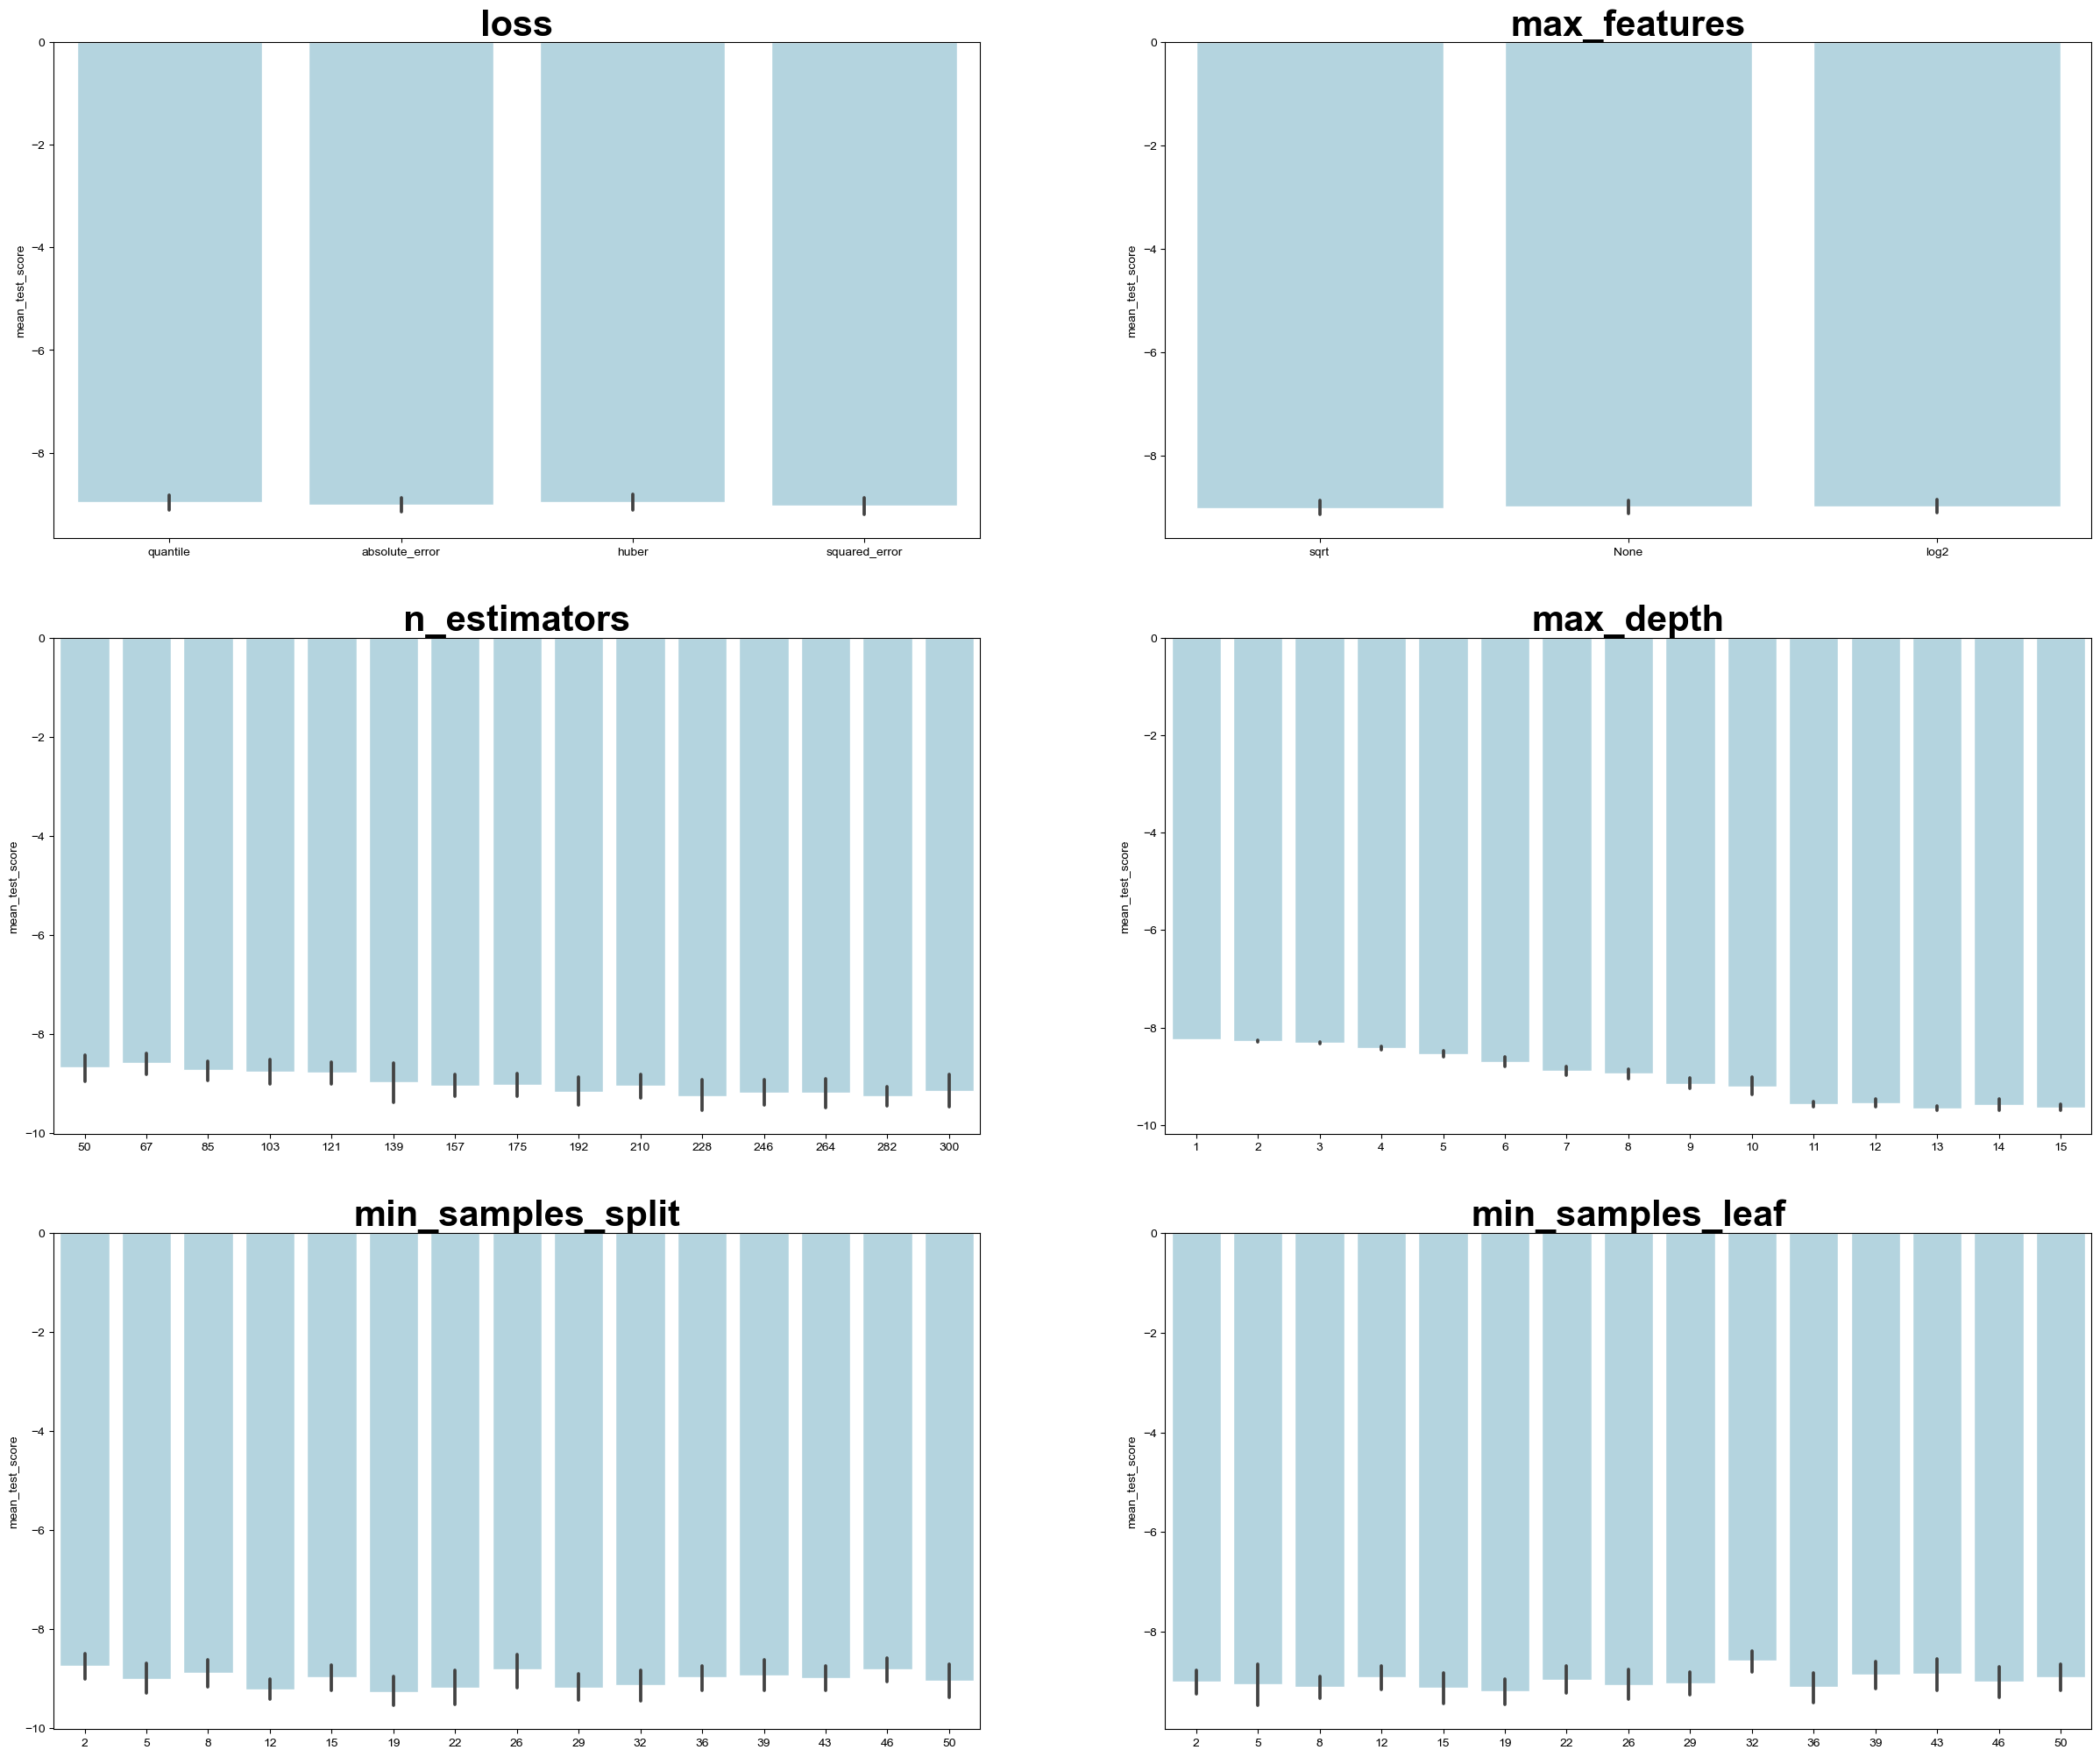

In [8]:
rs_df = pd.DataFrame(random_cv.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df.loc[rs_df['param_reg__max_features'].isna(), 'param_reg__max_features'] = 'None'

cols = [
    'param_reg__loss', 
    'param_reg__max_features',
    'param_reg__n_estimators',
    'param_reg__max_depth',
    'param_reg__min_samples_split',
    'param_reg__min_samples_leaf'
]
pref = 'param_reg__'

fig, axs = plt.subplots(ncols=2, nrows=3)
fig.set_size_inches(30,25)
sns.set(font_scale=2)
color = 'lightblue'
i = 0
j = 0

for col in cols:
    sns.barplot(
        x=col,
        y='mean_test_score', 
        data=rs_df, 
        ax=axs[i,j], 
        color=color
    )
    axs[i,j].set_title(
        label=col.replace(pref, ''), 
        size=30, 
        weight='bold'
    )
    axs[i,j].set_xlabel('')
    j += 1
    if j == 2:
        i += 1
        j = 0

Graphs suggest that there is no significant benefit or compelling reason to choose higher values for the hyperparameters. Therefore, it would be prudent to continue with the GridSearchCV approach and explore a wider range of hyperparameter values to find the optimal configuration for your model. By systematically searching through different combinations of hyperparameters, GridSearchCV can help identify the best parameter values that improve the model's performance.

In [9]:
loss = ['absolute_error']
max_features = ['log2', None]
n_estimators = range(45, 55)
max_depth = range(1, 6)
min_samples_split = range(2, 9, 2)
min_samples_leaf = range(2, 9, 2)

hyperparameter_grid = {
    'reg__loss': loss,
    'reg__max_features': max_features,
    'reg__n_estimators': n_estimators,
    'reg__max_depth': max_depth,
    'reg__min_samples_split': min_samples_split,
    'reg__min_samples_leaf': min_samples_leaf
}

grid_cv = GridSearchCV(
    estimator=pipeline,
    param_grid=hyperparameter_grid,
    cv=3, 
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_cv.fit(X_train, y_train)
best_params = grid_cv.best_params_

print()
print('Best params:')
print(best_params)
print()
print('Best score:', grid_cv.best_score_)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


[16:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "loss", "max_features", "min_samples_leaf", "min_samples_split" } are not used.


Best params:
{'reg__loss': 'absolute_error', 'reg__max_depth': 1, 'reg__max_features': 'log2', 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 2, 'reg__n_estimators': 54}

Best score: -8.231250874509774


In [11]:
pipeline.set_params(**best_params)

pipeline.fit(X_train, y_train)
y_pred = np.round(pipeline.predict(X_test))
print(f'MSE for test subset: {mean_squared_error(y_test, y_pred)}')

[19:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "loss", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

MSE for test subset: 8.480150198346607


In [16]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE for test subset: {rmse}')

RMSE for test subset: 2.8763235564338165


In [15]:
# Define a dictionary of intensity levels and descriptions
intensity_descriptions = {
    1: 'Very low intensity: Suitable for individuals with minimal physical activity," \nsuch as "Walking at a leisurely pace," "Stretching or yoga," and "Gentle swimming."\nHowever, please note that your preference is prioritized.',
    2: 'Low intensity: Suitable for beginners or individuals with limited physical activity," \nsuch as "Light jogging or running," "Cycling at a relaxed pace," and "Beginner\'s aerobics." \nHowever, please remember that your preference takes priority.',
     3: 'Moderate intensity: Suitable for individuals who engage in regular physical activity,\n including "Brisk walking," "Dancing," and "Water aerobics."\nHowever, please keep in mind that your preference is given priority.',
    4: 'Medium intensity: Suitable for individuals with moderate fitness and physical activity, \nsuch as "Power walking," "Cycling at a moderate pace," and "Zumba."\nHowever, please remember that your preference is given priority.',
    5: 'Moderate to high intensity: Suitable for individuals with moderate to high fitness levels,\n including "Jogging or running at a moderate pace," "High-intensity interval training (HIIT)," and "Kickboxing."\nHowever, please note that your preference is given priority.',
    6: 'High intensity: Suitable for individuals with a high level of fitness and physical activity,\n such as "Running at a fast pace," "Circuit training," and "CrossFit."\nHowever, please keep in mind that your preference is given priority.',
    7: 'High intensity: Suitable for individuals with a high level of fitness and physical activity,\n such as "Advanced HIIT workouts," "Competitive sports (e.g., soccer, basketball)," and "Spinning or indoor cycling classes."\nHowever, please remember that your preference is given priority.',
    8: 'Very high intensity: Suitable for individuals with very high fitness and physical activity,\n including "Sprinting or interval sprints," "Plyometric exercises," and "Heavy weightlifting."\nHowever, please keep in mind that your preference is given priority.',
    9: 'Very higher intensity: Suitable for individuals with very high fitness and physical activity,\n such as "Advanced CrossFit workouts," "Box jumps," and "Olympic weightlifting."\nHowever, please note that your preference is given priority.',
    10: 'Extremely high intensity: Suitable for athletes or individuals with exceptional fitness levels,\n including "Professional sports training," "Marathon running," and "Elite-level strength and conditioning programs."\nHowever, please remember that your preference is given priority.'
}

# Select features and target variables
x = df[['Calories Burn', 'Dream Weight', 'Actual Weight', 'Age', 'Duration', 'Heart Rate', 'BMI', 'Gender', 'Weather Conditions']]
x = pd.get_dummies(x, columns=['Gender', 'Weather Conditions'], drop_first=True)
y = df['Exercise Intensity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)

# Train the XGBoost regressor
rf = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=26)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Convert the predictions to intensity levels (rounding to the nearest integer)
predicted_intensities = np.round(y_pred).astype(int)

# Calculate accuracy
rf_rmse = np.sqrt(mean_squared_error(y_test, predicted_intensities))
print("RMSE:", rf_rmse)

# Prompt user for input
dream_weight = float(input("Enter your dream weight: "))
actual_weight = float(input("Enter your actual weight: "))
height = float(input("Enter your height in meters: "))
calories_burn = float(input("Enter the calories burned: "))
heart_rate = float(input('Enter your desired Heart rate:'))
weather_conditions = input("Enter your suitable training weather condition: ")
age = float(input("Enter your age: "))
gender = input("Enter your Gender (M/F): ")
duration = float(input("Enter your training session duration (minutes): "))

# Calculate BMI
bmi = actual_weight / (height ** 2)

# Create a dataframe with user input
user_input = pd.DataFrame(
    [[calories_burn, dream_weight, actual_weight, age, duration, heart_rate, bmi, gender, weather_conditions]],
    columns=['Calories Burn', 'Dream Weight', 'Actual Weight', 'Age', 'Duration', 'Heart Rate', 'BMI',
             'Gender', 'Weather Conditions'])

# Add missing columns to the user input DataFrame
missing_columns = set(X_train.columns) - set(user_input.columns)
for column in missing_columns:
    user_input[column] = 0

# Reorder the columns to match the training data
user_input = user_input[X_train.columns]

# Make predictions on the user input
predicted_intensity_selected = int(round(rf.predict(user_input)[0]))

# Retrieve the description based on the predicted intensity level
description = intensity_descriptions.get(predicted_intensity_selected, "Unknown")

# Display the recommendation and intensity description
print("Recommended Exercise Intensity:", predicted_intensity_selected)
print("Intensity Description:", description)

RMSE: 2.9191782312124683
Recommended Exercise Intensity: 6
Intensity Description: High intensity: Suitable for individuals with a high level of fitness and physical activity,
 such as "Running at a fast pace," "Circuit training," and "CrossFit."
However, please keep in mind that your preference is given priority.
